
<div style="text-align: center; font-weight: bold;">
    <h1>Pipeline for Research ready EHR Datasets</h1>
    <h2>Part 1: Accessing, Understanding and Summarizing the EHR Data</h2>
    <h4>Author: Vidul Ayakulangara Panickan</h3>
</div>




## Step 1: Gaining Access to Data
We will be using MIMIC for our demo example. For mimic, you need to go through the following steps to gain acceess

## Step 2: Understanding The Data
After gaining access to the raw EHR data, the first step is to understand how

1. How the data is stored.
2. How the data is organized.
3. What are the key concepts in the data



The EHR data will come with its own data documentation or there will be data maintainer with whom you can consult to learn more. For MIMIC data, it comes with a data documentation you can refer [here](https://mimic.mit.edu/docs/iv/)

### Data Storage
EHR data is typically stored in hospital databases. However sometimes, they are also provided as flat files. For MIMIC, the dataset is provided as compressed csv files. The data is located in /files/mimiciv/3.1/ under two modules: icu and hosp in compressed format. If you are on an unix system, you can use the following code to uncompress/unzip
wget -r -N -c -np --user apvidul --ask-password https://physionet.org/files/mimiciv/3.1/

For MIMIC, the data is located in /files/mimiciv/3.1/ under two modules: icu and hosp in compressed format. If you are on an unix system, you can use the following code to uncompress/unzip


In [2]:
#The following code unzips the files and automatically removes the orginal zipped files

gunzip ./physionet.org/files/mimiciv/3.1/hosp/*.gz
gunzip ./physionet.org/files/mimiciv/3.1/icu/*.gz

SyntaxError: invalid syntax (3382902408.py, line 3)

### Data Organization
The standard [MIMIC-IV](https://physionet.org/content/mimiciv/3.1/) data provides two data modules: Hosp and ICU. There are other modules containing Emergecy department data, Chest X-Rays, ECG available to be downloaded from other MIMIC datasets listed [here](https://mimic.mit.edu/docs/iv/modules/). For the scope of this tutorial, we will be focussing on just the standard mimic dataset the comes with Hosp and ICU modules.

#### Hosp Module: 
Consists of  all data acquired from the hospital wide electronic health record. This includes patient information, lab measurements, microbiology, medication administered, and billed diagnoses. Information on tables in this module can be read [here](https://mimic.mit.edu/docs/iv/modules/hosp/)

In this tutorial, we will be focussing on tables neccessary to create analysis ready dataset namely.

1) Data Dictionaries: These tables contain definition for the medical codes used in the EHR Data:
- d_hcpcs - provides a description of CPT codes.
- d_icd_diagnoses - provides a description of ICD-9/ICD-10 billed diagnoses.
- d_icd_procedures - provides a description of ICD-9/ICD-10 billed procedures.
- d_labitems - provides a description of all lab items.

2) Event Tables: These tables contain events recorded in hospital over time.
- diagnoses_icd - Billed ICD-9/ICD-10 diagnoses codes for hospitalizations. This type of data is generally referred to as Diagnosis data
- drgcodes - Billed diagnosis related group (DRG) codes for hospitalizations. This type of data is generally referred to as Medication data
- hpcsevents - Billed events occurring during the hospitalization. Includes CPT codes. This type of data is generally referred to as Procedure data
- labevents - Laboratory measurements sourced from patient derived specimens. This type of data is generally referred to as Lab data
- procedures_icd - Billed procedures for patients during their hospital stay. This type of data is generally referred to as Procedure data

3) Patient Metadata: These tables provide information on the patient during their stay in the hospital
- admissions table - Detailed information about hospital stays.
- transfers table - Detailed information about patients' unit transfers.
- patients table - Patients' gender, age, and date of death if information exists.
   

#### ICU Module: 
Consists of information collected from the clinical information system used within the ICU. Data includes intravenous administrations, ventilator settings, and other charted items. Information on tables in this module can be read [here](https://mimic.mit.edu/docs/iv/modules/icu/)

### Key Concepts in the Data

1. **Unique Patient ID**: A unique id that uniquely identifies a patient. In MIMIC data, every unique patient get a unique id called subject_id
2. **Event/Observation**: EHR data largely includes events or observation recorded over a period of time.
3. **Event/Observation Type**: Type of Event/Observation type that is recorded or observed. This can be Diagnosis, Medication, Lab, Procedure, Radiology, Note etc
4. **Time**: Time an event happened or observation was made
   

## Step 3: Summarize The Data
The idea is to get a sense of the data obtained and what it looks like. Like knowing how many unique patients there are in the data. What are the unique EHR codes used in the data. Can we account for all of them. Summarizing data also helps in identifying outliers and removing noise.

In [1]:
import pandas as pd
import os

os.makedirs("Summary", exist_ok=True)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Diagnoses Data

In [2]:
# Loading the tables as string format makes the data consistent throughout. 
diagnoses_icd_file = "/n/data1/hsph/biostat/celehs/lab/va67/MIMIC/mimic-iv-codified-3.1/files/mimiciv/3.1/hosp/diagnoses_icd.csv"

diagnoses_icd = pd.read_csv(diagnoses_icd_file,dtype=str)

# We first take a look at the data by displaying the first few rows
diagnoses_icd.head()

# We then summarize the data
diagnoses_icd.describe()

,subject_id,hadm_id,seq_num,icd_code,icd_version
count,6364488,6364488,6364488,6364488,6364488
unique,223291,545497,39,28562,2
top,12468016,27635276,1,4019,10
freq,2396,57,545507,102368,3455747


From the above data summary, we see that there are 223291 unique patients in the diagnoses table. It's also vital to recognize every medical code in the EHR data - avoiding them can lead to missing data. From the above table we see that there are 28562 unique ICD codes and there are two version: ICD9 and ICD10

In [3]:
''' Above we load the entire data at once as diagnosis datasets is relatively small. However if the dataset is large like lab data or ECG,
the data points, we would need to use other methods. Below we define a custom summarzing function to summarize larger datasets. 
The function reads data in batches, summarized and further provides frequency of individual EHR elements '''

def summarize(filepath, batch_size, dataframe=None):
    frequencies = {}
    non_null_records_count = {}
    total_records_count = 0

    for batch in pd.read_csv(filepath, chunksize=batch_size, dtype=str):

        total_records_count += batch.shape[0]

        for column in batch.columns:
            if column not in frequencies:
                frequencies[column] = {}
                non_null_records_count[column] = 0

            # Counting the number of non null records in each batch
            non_null_records_count[column] += batch[column].count()

            for item in batch[column]:
                if item in frequencies[column]:
                    frequencies[column][item] += 1
                else:
                    frequencies[column][item] = 1

    freq_table = [
        (column, len(frequencies[column]), non_null_records_count[column])
        for column in frequencies
    ]


    summary = pd.DataFrame(
            freq_table, columns=["Column_Name", "Unique_Values", "Non_Null_Records"]
        )
    

    return {'summary':summary,'freq':frequencies,'records':total_records_count}

In [40]:
#Now lets summarize the data using the function we defined above.

summarize_output= summarize(diagnoses_icd_file, 5000000)
print("Total number of records:", summarize_output['records'])


# Saving the summary to Summary folder
summarize_output['summary'].to_csv("./Summary/Diagnoses_basic_summary.csv",index=None)

# The sorted frequency count of icd codes is also saved in the summary folder
sorted_icd_freq = pd.DataFrame(summarize_output['freq']['icd_code'].items(),columns=['icd_code','count']).sort_values(by='count',ascending=False)
sorted_icd_freq.to_csv("./Summary/diagnoses_patient_counts.csv",index=None)

summarize_output['summary']

Total number of records: 6364488


,Column_Name,Unique_Values,Non_Null_Records
0,subject_id,223291,6364488
1,hadm_id,545497,6364488
2,seq_num,39,6364488
3,icd_code,28562,6364488
4,icd_version,2,6364488


In [38]:
import heapq

dataframes =[]
for dataset_column in column_frequencies:
    dataframes.append(pd.DataFrame(heapq.nlargest(10, column_frequencies[dataset_column].items(), key=lambda x: x[1]), columns=[dataset_column,dataset_column+'_count']))

sorted_icd_freq = pd.DataFrame(column_frequencies['icd_code'].items(),columns=['icd_code','count']).sort_values(by='count',ascending=False)
sorted_icd_freq.to_csv("./Summary/diagnoses_patient_counts.csv",index=None)

dataframes_combined = pd.concat(dataframes,axis=1)
dataframes_combined 



,subject_id,subject_id_count,hadm_id,hadm_id_count,seq_num,seq_num_count,icd_code,icd_code_count,icd_version,icd_version_count
0,12468016,2396,27635276,57,1,545507,4019,102368,10,3455747.0
1,18284271,2077,23076003,50,2,531552,E785,84570,9,2908741.0
2,10577647,1850,24773199,42,3,508643,I10,83775,NaN,NaN
3,15114531,1840,23549273,39,4,482201,2724,67293,NaN,NaN
4,11582633,1777,22987108,39,5,452724,Z87891,62806,NaN,NaN
5,13475033,1721,21312888,39,6,421439,K219,56157,NaN,NaN
6,15404950,1694,24996125,39,7,389019,53081,48628,NaN,NaN
7,18902344,1616,23798746,39,8,356515,25000,43077,NaN,NaN
8,11389314,1598,28265343,39,9,324023,F329,41876,NaN,NaN
9,12251785,1589,26072491,39,10,292773,I2510,41550,NaN,NaN


From above we can gather the following
1. The most recorded ICD code is 4019 which corresponds to  "Unspecified essential hypertension"
2. The subject with hospital admission id 27635276 had the most diagnoses recorded during a single visit
3. We have more icd version 10 codes recorded than icd 9 code

Some of the information is essential to save such as most frequently recorded diagnoses.

If you want to see how many patients had a particular diagnoses, you can take unique pairs of subject_id and icd code and generate frequency for icd code. This can also help in future in case you need to look up the size of a patient cohort if you are interested in performing research/study on a certain disease or condition.


In [7]:
unique_subject_icd_pairs = diagnoses_icd[['subject_id', 'icd_code','icd_version']].drop_duplicates()

icdcode_frequencies = unique_subject_icd_pairs[['icd_code','icd_version']].value_counts().reset_index(name='counts')

sorted_icdcode_frequencies = icdcode_frequencies.rename(columns={'index': 'icd_code'}).sort_values(by='counts', ascending=False)

sorted_icdcode_frequencies.head(10)

,icd_code,icd_version,counts
0,4019,9,52360
1,I10,10,48611
2,E785,10,45431
3,2724,9,35210
4,Z87891,10,32523
5,K219,10,30093
6,53081,9,25203
7,Z20822,10,23629
8,F419,10,23305
9,F329,10,23110


This is great, however we do not know what these icd codes corresponds to at this point. Usually EHR datasets comes with
data dictionaries which contains EHR codes and their defenitions. For MIMIC the ICD codes are defined in the d_icd_diagnoses table. 

In [8]:
d_icd_diagnoses_file = "/n/data1/hsph/biostat/celehs/lab/va67/MIMIC/mimic-iv-codified-3.1/files/mimiciv/3.1/hosp/d_icd_diagnoses.csv"

# Ensure that we load the dictionary in the same format as the original dataset. Here we load everything as string
data_dictionary_icd = pd.read_csv(d_icd_diagnoses_file,dtype=str)

# Display the first 10 rows
data_dictionary_icd.head(10)

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A
5,0022,9,Paratyphoid fever B
6,0023,9,Paratyphoid fever C
7,0029,9,"Paratyphoid fever, unspecified"
8,0030,9,Salmonella gastroenteritis
9,0031,9,Salmonella septicemia


In [11]:
#Now we combine the two datasets to get the icd code frequency along with icd code descriptions

print(sorted_icdcode_frequencies.shape)

sorted_icdcode_frequencies_w_def = pd.merge(sorted_icdcode_frequencies, data_dictionary_icd, on=['icd_code','icd_version'], how='left')

sorted_icdcode_frequencies_w_def

(28583, 3)


,icd_code,icd_version,counts,long_title
0,4019,9,52360,Unspecified essential hypertension
1,I10,10,48611,Essential (primary) hypertension
2,E785,10,45431,"Hyperlipidemia, unspecified"
3,2724,9,35210,Other and unspecified hyperlipidemia
4,Z87891,10,32523,Personal history of nicotine dependence
...,...,...,...,...
28578,T8161XA,10,1,Aseptic peritonitis due to foreign substance a...
28579,T81710A,10,1,Complication of mesenteric artery following a ...
28580,Z8651,10,1,Personal history of combat and operational str...
28581,W5301XD,10,1,"Bitten by mouse, subsequent encounter"


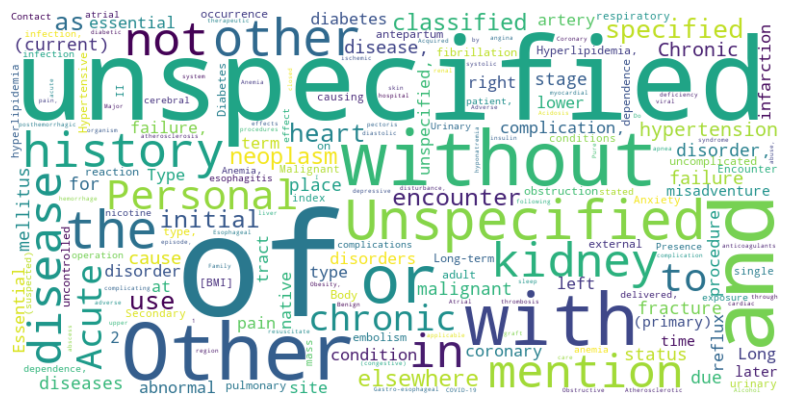

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary for the word cloud, where the keys are words and values are their frequencies

word_freq = {}
for index, row in sorted_icdcode_frequencies_w_def.iterrows():
    title = row['long_title']
    count = row['counts']
    for word in title.split():
        word_freq[word] = word_freq.get(word, 0) + count

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the Word Cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

 Each raw medical code is categorized under either a standard coding system (i.e. ICD, NDC, or NDF-RT) or a local system specific to an institution.

In [ ]:
#Create folder and save summary level data
# Also look at date range